# Machine Learning Coursework 2

## Web References

- [The Iris Dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html)
- [sklearn.datasets.load_iris](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html)
- [Iris Species:100% Accuracy using Naive bayes](https://www.kaggle.com/vinayshaw/iris-species-100-accuracy-using-naive-bayes)
- [Naive Bayes Classifier with Scikit](https://python-course.eu/machine-learning/naive-bayes-classifier-with-scikit.php)
- [scikit-learn Classifiers on Iris Dataset](https://www.kaggle.com/chungyehwang/scikit-learn-classifiers-on-iris-dataset)
- [Random Forest Feature Importance Computed in 3 Ways with Python](https://mljar.com/blog/feature-importance-in-random-forest/#:~:text=Random%20Forest%20Built-in%20Feature%20Importance&text=It%20is%20a%20set%20of,sets%20with%20similars%20responses%20within.)
- [Accuracy, Precision, Recall & F1-Score – Python Examples](https://vitalflux.com/accuracy-precision-recall-f1-score-python-example/)

## Import Libraries

In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# set the randon seed to use for reproducibility
random_state = 1337

# the fraction of the data to use for testing
test_frac = 0.5

## 1. Classifiers [7 marks total]

In [3]:
# import datasets
from sklearn import datasets 

# load data
iris = datasets.load_iris() # load data 

In [4]:
# get the predictors and target
X = iris.data
y = iris.target

In [5]:
# split the dataset into training and test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_frac, 
    stratify=y,
    random_state=random_state)

print('There are %d samples in the training set and %d samples in the test set' % (X_train.shape[0], X_test.shape[0]))

There are 75 samples in the training set and 75 samples in the test set


### a) Baseline

The Pycaret library is use in this section to establish a baseline for model performance.

> ℹ️ This section is not core the answering the coursework questions.

In [6]:
# import the pycaret dependencies
from pycaret.classification import *

In [7]:
# convert the training dataset to a dataframe
df_train = pd.DataFrame(data=X_train, columns=iris.feature_names)
df_train['target'] = pd.Series(y_train)

# convert the test data to a dataframe
df_test = pd.DataFrame(data=X_test, columns=iris.feature_names)
df_test['target'] = pd.Series(y_test)

In [8]:
# initialize the training environment and transformation pipeline
classifier = setup(
    data=df_train, 
    target='target',
    session_id=random_state,
    silent=True,
    verbose=False)

In [9]:
# train a naive bayes, random forest, and knn classification model
models = compare_models(include=['nb', 'rf', 'knn'], n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.9467,0.9917,0.9500,0.9678,0.9444,0.9206,0.9317,0.4230
rf,Random Forest Classifier,0.9433,1.0000,0.9500,0.9356,0.9322,0.9194,0.9361,0.3400
knn,K Neighbors Classifier,0.9267,1.0000,0.9333,0.9544,0.9231,0.8893,0.9052,0.0120


The following section optimizes each model by using a [random grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) from the scikit-learn library.

In [10]:
# find the best hyperparameters for each model
tuned_models = [tune_model(model,search_library='scikit-learn', search_algorithm='random') for model in models]

# display the model parameters
for model in models:
    print(model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8333,1.0000,0.8333,0.8889,0.8222,0.7500,0.7833
1,0.8333,1.0000,0.8333,0.8889,0.8222,0.7500,0.7833
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,0.8000,1.0000,0.8333,0.8667,0.7867,0.6875,0.7350
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
9,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


GaussianNB(priors=None, var_smoothing=1e-09)
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1337, verbose=0,
                       warm_start=False)
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


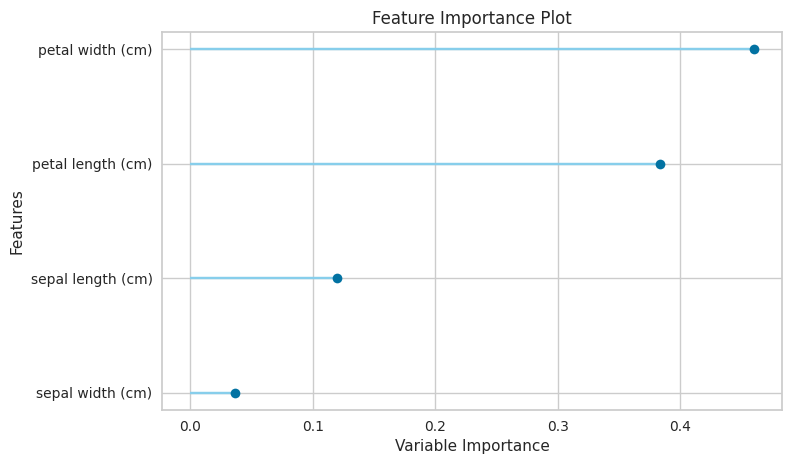

In [11]:
# show the feature importance of the random forest model
for model in models:
    if type(model).__name__ == 'RandomForestClassifier':
        plot_model(model, plot='feature')

In [12]:
# evaluate each model on the test data
for model in tuned_models:
    print('--- %s ---' % type(model))

    df_predicted = predict_model(estimator=model, data=df_test)
    print(classification_report(y_true=df_predicted.target, y_pred=df_predicted.Label, target_names=iris.target_names))

--- <class 'sklearn.naive_bayes.GaussianNB'> ---
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        25
  versicolor       0.89      1.00      0.94        25
   virginica       1.00      0.88      0.94        25

    accuracy                           0.96        75
   macro avg       0.96      0.96      0.96        75
weighted avg       0.96      0.96      0.96        75

--- <class 'sklearn.ensemble._forest.RandomForestClassifier'> ---
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        25
  versicolor       0.86      1.00      0.93        25
   virginica       1.00      0.84      0.91        25

    accuracy                           0.95        75
   macro avg       0.95      0.95      0.95        75
weighted avg       0.95      0.95      0.95        75

--- <class 'sklearn.neighbors._classification.KNeighborsClassifier'> ---
              precision    recall  f1-score   supp

### b) Modeling Functions

This section contains re-usable functions to reduce the amount of repeated code.

In [13]:
class Modeler:
    """
    Modeler class to train and evaluate models.
    """
    def __init__(self, model, X_train, y_train, X_test, y_test, feature_names, target_names):
        """
        Initialize the modeler.

        Parameters
        ----------
        model : sklearn model
            The model to train and evaluate.
        X_train : numpy array
            The training data.
        y_train : numpy array
            The training labels.
        X_test : numpy array
            The test data.
        y_test : numpy array
            The test labels.
        feature_names : list
            The feature names.
        target_names : list
            The target names.
        """
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.feature_names = feature_names
        self.target_names = target_names

    def train(self):
        """
        Train the model
        """
        self.model.fit(self.X_train, self.y_train)

    def evaluate(self):
        """
        Evaluate the model
        """
        y_predicted = self.model.predict(self.X_test)
        print(classification_report(y_true=self.y_test, y_pred=y_predicted, target_names=self.target_names))

    def get_feature_importance(self) -> pd.DataFrame:
        """
        Get the feature importance of the model.

        Returns
        -------
        pd.DataFrame
            The feature importance of the model.
        """
        if type(self.model).__name__ == 'RandomForestClassifier':
            return pd.DataFrame({
                'feature': self.feature_names,
                'importance': self.model.feature_importances_
            })
        else:
            print('Model does not support feature importance.')

    def get_evaluation(self) -> pd.DataFrame:
        """
        Get the evaluation of the model on the test dataset.

        Returns
        -------
        pd.DataFrame
            The evaluation of the model on the test dataset.
        """
        y_predicted = self.model.predict(self.X_test)
        return pd.DataFrame([{
            'model': type(self.model).__name__,
            'precision': precision_score(y_true=self.y_test, y_pred=y_predicted, average='weighted'),
            'recall': recall_score(y_true=self.y_test, y_pred=y_predicted, average='weighted'),
            'f1-score': f1_score(y_true=self.y_test, y_pred=y_predicted, average='weighted'),
            'accuracy': accuracy_score(y_true=self.y_test, y_pred=y_predicted)
        }])

    def get_accuracy(self) -> float:
        """
        Get the accuracy of the trained model on the test dataset.

        Returns
        -------
        float
            The accuracy of the model.
        """
        return accuracy_score(y_true=self.y_test, y_pred=self.model.predict(self.X_test))

### 1.1 Naïve Bayes Classifier [2]

#### 1.1.1 Train the Naive Bayes Classifier

In [14]:
# create a new modeler
modeler_nb = Modeler(
    model=GaussianNB(), 
    X_train=X_train, 
    y_train=y_train, 
    X_test=X_test, 
    y_test=y_test,
    feature_names=iris.feature_names,
    target_names=iris.target_names)

# train the model
modeler_nb.train()

In [15]:
# evaluation the model on the test set
modeler_nb.evaluate()

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        25
  versicolor       0.89      1.00      0.94        25
   virginica       1.00      0.88      0.94        25

    accuracy                           0.96        75
   macro avg       0.96      0.96      0.96        75
weighted avg       0.96      0.96      0.96        75



### 1.2 Random Forst Classifier [3]


#### 1.2.1 Train a random forest classifier 

In [16]:
# create a new modeler
modeler_rf = Modeler(
    model=RandomForestClassifier(
        n_jobs=-1,
        random_state=random_state
    ), 
    X_train=X_train, 
    y_train=y_train, 
    X_test=X_test, 
    y_test=y_test,
    feature_names=iris.feature_names,
    target_names=iris.target_names)

# train the model
modeler_rf.train()

In [17]:
# evaluation the model on the test set
modeler_rf.evaluate()

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        25
  versicolor       0.89      1.00      0.94        25
   virginica       1.00      0.88      0.94        25

    accuracy                           0.96        75
   macro avg       0.96      0.96      0.96        75
weighted avg       0.96      0.96      0.96        75



#### 1.2.2 Evaluate feature performance

The table below shows that the `sepal length (cm)` and `sepal width (cm)` features have very low importance in the model. Therefore, we can assume that removing these features will have a minimal impact on the model.

In [18]:
# show the importance of each feature
df_feature_importance = modeler_rf.get_feature_importance().sort_values(by='importance', ascending=False)
df_feature_importance

,feature,importance
3,petal width (cm),0.458948
2,petal length (cm),0.403974
0,sepal length (cm),0.094816
1,sepal width (cm),0.042261


Training a new model with the least important features removed creates a model with identical performance.

❗️ However, in datasets as small as the iris dataset, the test/train split and random seed can significantly impact the results, so we cannot conclude that model performance will always be precisely the same.

In [19]:
def create_rf_modeler(X_train, y_train, X_test, y_test, selected_features:list, random_state:int) -> Modeler:
    """
    Create a random forest modeler.

    Parameters
    ----------
    X_train : numpy array
        The training data.
    y_train : numpy array
        The training labels.
    X_test : numpy array
        The test data.
    y_test : numpy array
        The test labels.
    selected_features : list
        The selected features.
    random_state : int
        The random state.

    Returns
    -------
    Modeler
        The trained random forest modeler.
    """
    # create a new modeler
    modeler = Modeler(
        model=RandomForestClassifier(
            n_jobs=-1,
            random_state=random_state
        ), 
        X_train=X_train[:, selected_features], 
        y_train=y_train, 
        X_test=X_test[:, selected_features], 
        y_test=y_test,
        feature_names=None,
        target_names=iris.target_names)

    # train the model
    modeler.train()

    return modeler

In [20]:
# evalute model performance with only feature 2 and 3
selected_features = [2, 3]
modeler_rf_sel = create_rf_modeler(X_train, y_train, X_test, y_test, selected_features, random_state)

# evaluation the model on the test set
modeler_rf_sel.evaluate()

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        25
  versicolor       0.89      1.00      0.94        25
   virginica       1.00      0.88      0.94        25

    accuracy                           0.96        75
   macro avg       0.96      0.96      0.96        75
weighted avg       0.96      0.96      0.96        75



#### 1.2.3 Visualise the feature importance

Text(0.5, 1.0, 'Figure 1. Feature Importance')

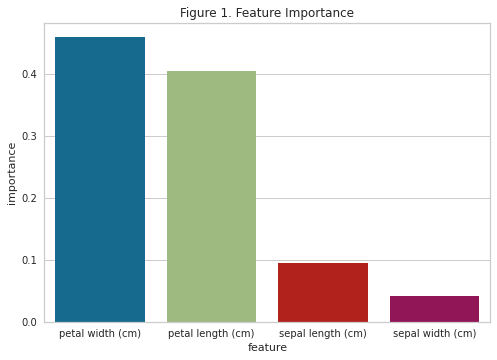

In [21]:
sns.barplot(
    data=df_feature_importance,
    x='feature',
    y='importance').set_title('Figure 1. Feature Importance')

### 1.3 kNN Classifier [2]

In [22]:
# create a new modeler
modeler_knn = Modeler(
    model=KNeighborsClassifier(n_jobs=-1), 
    X_train=X_train, 
    y_train=y_train, 
    X_test=X_test, 
    y_test=y_test,
    feature_names=iris.feature_names,
    target_names=iris.target_names)

# train the model
modeler_knn.train()

In [23]:
# evaluation the model on the test set
modeler_knn.evaluate()

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        25
  versicolor       0.93      1.00      0.96        25
   virginica       1.00      0.92      0.96        25

    accuracy                           0.97        75
   macro avg       0.98      0.97      0.97        75
weighted avg       0.98      0.97      0.97        75



## 2 Code Report [6 marks total]

The baseline section creates initial models with the  [PyCaret library](https://pycaret.org/) to understand if the approach is correct and the expected model performance baseline.

In section 1. b, a `Modeler` class is implemented to allow consistency and reduce repeated code when evaluating model performance. Creating a new class instance requires a scikit-learn model configured with the appropriate hyperparameters and the training and test data.

The class has the following methods:

-	` train` - Train the model by fitting the training data (`X_train` and `y_train`)
-	`evaluate` - This method use the trained model to predict labels for the test set (`X_test`), compare the output with the actual labels (`y_test`), and print a classification report for evaluation.
-	` get_feature_importance` - If the model is a ` RandomForestClassifier`, this function returns a data frame with the feature importance.
-	` get_evaluation` - This function is similar to `evaluate` but returns a data frame containing only the weighted average for the evaluation metrics.
-	` get_accuracy` - This function returns only the accuracy score for the predictions on the test set.

Each classifier (Naïve Bayes, Random Forest, and k-NN) is trained and evaluated using the `Modeler` class.

In further sections of the notebook, the following helper methods can are found:

-	` create_rf_modeler` - This function creates variations of the Random Forest for use in multiple experiments found in the notebook. One of the key input parameters is ` selected_features `, allowing model training to use only a subset of the features.
-	` backwards_elimination` - This function is specifically for experimentation with the Random Forest algorithm. The first step is to train n initial model with the entire feature set. Then the least important feature is iteratively removed until only a single feature remains. Finally, the results are returned a  data frame showing the feature removed at each set and the performance metrics of the resulting model.
-	` get_random_influence` - This function generates data to illustrate the influence of training the models on different datasets that results from only varying the random seed variable while keeping all other variables consistent.


## 3 Model Questions [14 marks total]

### 3.1 Naïves Bayes Questions [4]

#### 3.1.1 Why do zero probabilities in our Naïve Bayes model cause problems?

If an instance in the dataset has no training tuple (class label and particular attribute value), the frequency-based probability estimate will be zero (Naïve Bayes Algorithm: Everything you need to know, 2020), and the model is unable to make predictions

#### 3.1.2 How can we avoid the problem of zero probabilities in our Naïve Bayes model?

Techniques such as `Laplace` or `Lidstone` smoothing can be used to account for features not present in the training samples to prevent the problem of zero probabilities (1.9. Naive Bayes — scikit-learn 1.0.2 documentation, 2022).

For a simple illustration of how this might work: Add one to the frequency of every attribute value-class combination where the attribute value does not occur with every class value (Vashisht, 2020).

### 3.2 Random Forest Questions [6]

#### 3.2.1 Which feature is the most important from your random forest classifier?

Figure 1 (section 1.2.3) shows that `petal width (cm)` is the most important feature.

However, the Iris dataset is so simple that a boxplot (shown below) of each feature already reveals that the `petal width (cm)` and `petal length (cm)` have the least amount of overlap between the classes and accordingly have the most predictive power.

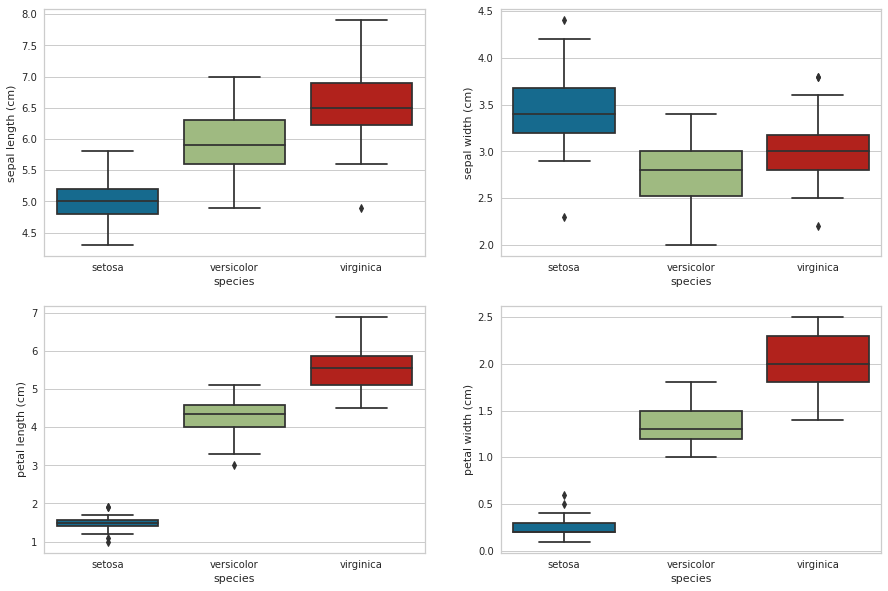

In [24]:
# load the dataset
bunch = datasets.load_iris(as_frame=True)
df_iris = bunch.data

# map the target integers to names
target_names = {}
for i, name in enumerate(bunch.target_names):
    target_names[i] = name

# join the species name to the feature dataframe
df_iris = df_iris.join(pd.Series(bunch.target.map(target_names), name='species'))

plt.figure(figsize=(15,10))
# create the plot
for i, feature in enumerate(bunch.feature_names):
   plt.subplot(2,2,i+1)
   sns.boxplot(data=df_iris, x='species', y=feature)

#### 3.2.2 Can any features be removed to increase accuracy of the model, if so which features?

In the experiment below, backward elimination by feature importance is used to iteratively remove a single feature and output the model metrics for each step for comparison (step 0 is the baseline using all the features). By examining this table, we can see that no feature can be removed to the model accuracy for the given random seed and training-test split used in this notebook. At best, we can remove the two `sepal` features to get the same accuracy as when using all features.

In the second experiment, we see that if we are limited to the removal of only one feature, the best choice would be `sepal length (cm)`, which again produces a model with the same accuracy as using the complete feature set.

In [25]:
def backward_elimination(X_train, y_train, X_test, y_test, random_state, feature_names=None, feature_dictionary=None, elimination_feature=None, results:pd.DataFrame = pd.DataFrame()) -> pd.DataFrame:
    """
    Backwards elimination of features.

    Parameters
    ----------
    X_train : numpy.ndarray
        The training dataset.
    y_train : numpy.ndarray
        The target values of the training dataset.
    X_test : numpy.ndarray
        The test dataset.
    y_test : numpy.ndarray
        The target values of the test dataset.
    random_state : int
        The random state.
    feature_names : list
        The feature names.

    Returns
    -------
    pd.DataFrame
        The results of the backward elimination.
    """
    # create the feature dictionary
    if (feature_dictionary is None):
        feature_dictionary = {}
        for (i, feature_name) in enumerate(feature_names):
            feature_dictionary[i] = feature_name

    # get the selected features for training
    selected_features = list(feature_dictionary.keys())

    # create the trained random forest modeler
    modeler = create_rf_modeler(X_train, y_train, X_test, y_test, selected_features, random_state)

    # get the evaluation of the model on the test set   
    df_evaluation = modeler.get_evaluation().iloc[: , 1:]
    df_evaluation.insert(0, 'eliminated', elimination_feature)
    results = results.append(df_evaluation, ignore_index=True)

    # feature elimination stops when a single feature remains
    if len(feature_dictionary) > 1:
        # get the feature to remove
        df_feature_importance = modeler.get_feature_importance().sort_values(by='importance', ascending=True)
        elimination_feature_index = df_feature_importance.index[0]
        elimination_feature = list(feature_dictionary.keys())[elimination_feature_index]

        # get the name of the eliminated feature
        elimination_feature_name = feature_dictionary[elimination_feature]

        # remove the feature and perform the next iteration
        del feature_dictionary[elimination_feature]
        results = backward_elimination(X_train, y_train, X_test, y_test, random_state, feature_dictionary=feature_dictionary, elimination_feature=elimination_feature_name, results=results)
        return results
    else:
        return results

backward_elimination(X_train, y_train, X_test, y_test, random_state, feature_names=iris.feature_names)

,eliminated,precision,recall,f1-score,accuracy
0,None,0.964286,0.960000,0.959855,0.960000
1,sepal width (cm),0.954023,0.946667,0.946323,0.946667
2,sepal length (cm),0.964286,0.960000,0.959855,0.960000
3,petal length (cm),0.954023,0.946667,0.946323,0.946667


In [26]:
# get the metrics with no features removed
selected_features = list(range(len(iris.feature_names)))
modeler_rf_sel = create_rf_modeler(X_train, y_train, X_test, y_test, selected_features, random_state)
results = modeler_rf_sel.get_evaluation().iloc[: , 1:]
results.insert(0, 'features', str(selected_features))

# experiment with removal of single features
for i, feature in enumerate(iris.feature_names):
    selected_features = list(range(len(iris.feature_names)))
    del selected_features[i]
    modeler_rf_sel = create_rf_modeler(X_train, y_train, X_test, y_test, selected_features, random_state)
    df_evaluation = modeler_rf_sel.get_evaluation().iloc[: , 1:]
    df_evaluation.insert(0, 'features', str(selected_features))
    results = results.append(df_evaluation, ignore_index=True)
results

,features,precision,recall,f1-score,accuracy
0,"[0, 1, 2, 3]",0.964286,0.960000,0.959855,0.960000
1,"[1, 2, 3]",0.964286,0.960000,0.959855,0.960000
2,"[0, 2, 3]",0.954023,0.946667,0.946323,0.946667
3,"[0, 1, 3]",0.954023,0.946667,0.946323,0.946667
4,"[0, 1, 2]",0.935484,0.920000,0.918831,0.920000


#### 3.2.3 Explain why it would be useful to remove these features.

In general, reducing the number of features can be considered a good idea if the model performance remains very similar as it will decrease the model complexity. For example, when creating linear regression models, the  [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion) (Akaike information criterion) estimator can be used for model selection as it is specifically concerned with the trade-off between the goodness of fit and the simplicity of the model.

In the context of Random Forest models, model performance might improve by removing features in some instances. For example, model performance can improve if there are highly correlated features causing overfitting in the model.

In [27]:
bunch.data.corr()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.000000,-0.117570,0.871754,0.817941
sepal width (cm),-0.117570,1.000000,-0.428440,-0.366126
petal length (cm),0.871754,-0.428440,1.000000,0.962865
petal width (cm),0.817941,-0.366126,0.962865,1.000000


### 3.3 kNN Questions [4]

#### 3.3.1 Do you think the kNN classifier is best suited to the iris dataset?

In section 4.2, experimental data is generated by training three classifiers (Naïve Bayes, Random Forest, and kNN) on 100 different training samples that result from varying the random seed used for the training/test split and calculating the accuracy on the test set. From this data, the `KNeighborsClassifier` (kNN) model has the highest mean accuracy indicating that this model is the best suited for the iris dataset.

The kNN classifier should also perform the best for the given dataset if we examine it from a theoretical viewpoint in that the ideal qualities listed in the section below holds.


#### 3.3.2 What ideal qualities would the most appropriate dataset display?

According to (Kumar, 2020) and various other sources, the kNN algorithm is most effective for datasets that exhibit the following qualities:

-	The dataset is appropriately labelled and does not contain empty (NaN or NA) values.
-	The data is noise-free. kNN can model complex boundaries between two classes and is sensitive to noisy data.
-	The dataset is relatively small. This is because the kNN classifier has to store the training data to make predictions. Therefore using a large dataset is computationally expensive in terms of time and storage. (Brownlee, 2020)
-	A small number of features is used since the algorithm suffers from the curse of dimensionality if the number of features becomes very large.

## 4 Comparing Models [18 marks total]

In [28]:
# display the model metrics for the test set
pd.concat([
    modeler_nb.get_evaluation(),
    modeler_rf.get_evaluation(),
    modeler_knn.get_evaluation()
])

,model,precision,recall,f1-score,accuracy
0,GaussianNB,0.964286,0.960000,0.959855,0.960000
0,RandomForestClassifier,0.964286,0.960000,0.959855,0.960000
0,KNeighborsClassifier,0.975309,0.973333,0.973291,0.973333


### 4.1 Compare each model [3]
What differences do you see between your Naïve Bayes classifier, your random forest classifier, and your kNN classifier? 

| Algorithm     | Notes                                                                                                                                                                                                                                                                                                                                                 | Accuracy | Training<br />Time | Inference<br />Time | Bias | Variance |
|---------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------|---------------|----------------|------|----------|
| NaïveBayes    | a) Precision, recall, f1-score and accuracy is identical to the Random Forest Classifier. <br />b) The performance metrics for each class is also identical to the Random Forest classifier. <br />c) This model has the lowest combined training and inference time.                                                                                             | 0.960    | 0.1s          | 0.1s           | High | Low      |
| Random Forest | a) All performance metrics are identical to the Naïve Bayes classifier. <br />b) This classifier has the highest training time, but inference time is as low as the Naïve Bayes classifier.                                                                                                                                                                  | 0.960    | 0.6s          | 0.1s           | Low  | High     |
| kNN           | a) The kNN classifier has the best performance metrics on the test set. <br />b) While the training time is as fast as the Naïve Bayes classifier, this model has the longest inference time. <br />This observation is also reflected in theory for kNN models suggesting that this kNN might not be the best <br />choice if high-frequency predictions are required. | 0.973    | 0.1s          | 0.2s           | Low  | High     |

Notes:

- Performance metrics are taken from the following sections:  1.1.1, 1.2.1, and 1.3. The metrics are on the test dataset.
- Training and Inference time are taken from the cell execution time as measured by Visual Studio Code on a MacBook Pro (16-inch, 2019).
- Inference time refers to the time taken for performing predictions on the test set and producing the performance metrics.
- Bias and Variance are known properties for the algorithms and were not directly measured.

### 4.2 Accuracy [6]
Can you explain why there are differences in accuracy between the three classifiers? 

In [30]:
#Write your answer here



| Algorithm     | Bias | Variance |
| ------------- | ---- | -------- |
| Naive Bayes   | High | Low      |
| Random Forest | Low  | High     |
| kNN           | Low  | High     |

https://machinelearningmastery.com/different-results-each-time-in-machine-learning/

- Variance: How sensitive the algorithm is to the specific data used during training.
- A more sensitive algorithm has a larger variance, which will result in more difference in the model, and in turn, the predictions made and evaluation of the model. Conversely, a less sensitive algorithm has a smaller variance and will result in less difference in the resulting model with different training data, and in turn, less difference in the resulting predictions and model evaluation.
 
 https://machinelearningmastery.com/gentle-introduction-to-the-bias-variance-trade-off-in-machine-learning/

- Low Bias: Suggests less assumptions about the form of the target function.
- High-Bias: Suggests more assumptions about the form of the target function.
- Examples of low-bias machine learning algorithms include: Decision Trees, k-Nearest Neighbors and Support Vector Machines.
- Examples of high-bias machine learning algorithms include: Linear Regression, Linear Discriminant Analysis and Logistic Regression.

 - Variance Error: Variance is the amount that the estimate of the target function will change if different training data was used.
 - The target function is estimated from the training data by a machine learning algorithm, so we should expect the algorithm to have some variance.
 - The k-nearest neighbors algorithm has low bias and high variance, but the trade-off can be changed by increasing the value of k which increases the number of neighbors that contribute t the prediction and in turn increases the bias of the model.

 https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6695655/
 - Naïve Bayes are not sensitive to dataset composition, whereas others e.g., hyperpipes (hip), k-nearest neighbors (lBk) and random forest (RF) are highly sensitive. Therefore, the best (or suitable) classifiers can only be selected if the dataset composition is also considered.

 https://www.analyticsvidhya.com/blog/2020/12/a-measure-of-bias-and-variance-an-experiment/

 - Random Forest - 	Low Bias, High Variance

 https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.579.2693&rep=rep1&type=pdf

 - High bias and low variance algorithms result in models that are more robust to changes in the training data since they are not close representations of that data.
- Naive Bayes is generally regarded as high bias and low variance because the assumptions it makes about the interactions among features have nothing to do with a particular training sample.

In [31]:
def get_random_influence(models:list, random_seeds:list, X, y, target_names, all_data:bool=False, stratify:bool=True) -> pd.DataFrame:
    """
    Experiment with the influence of the random seed on model accuracy.

    Parameters
    ----------
    models : list
        The list of models to evaluate.
    random_seeds : list
        The random seeds.
    X : numpy array
        The training data.
    y : numpy array
        The training labels.
    target_names : list
        The target names.
    all_data : bool, optional
        Whether to use all the data for training and testing.
    stratify : bool, optional
        Whether to stratify the data.

    Returns
    -------
    pd.DataFrame
        A dataframe containing the experiment results.
    """

    df_random_influence = pd.DataFrame(columns=['model', 'seed', 'accuracy'])
    for random_seed in random_seeds:
        if all_data:
            # use the complete dataset for training and testing
            X_train = X
            X_test = X
            y_train = y
            y_test = y
        else:
            # create the data split using the random seed
            X_train, X_test, y_train, y_test = train_test_split(
                X, y,
                test_size=test_frac, 
                stratify=y if stratify else None,
                random_state=random_seed)     

        # evaluate each model
        for model in models:
            if hasattr(model, 'random_state'):
                model.random_state = random_seed

            modeler = Modeler(
                model=model, 
                X_train=X_train, 
                X_test=X_test, 
                y_train=y_train, 
                y_test=y_test,
                feature_names=None,
                target_names=target_names)

            # train the model
            modeler.train()

            # get the model accuracy
            accuracy = modeler.get_accuracy()

            # add the model accuracy to the dataframe
            df_random_influence = df_random_influence.append(
                {
                    'model': model.__class__.__name__,
                    'seed': random_seed,
                    'accuracy': accuracy
                },
                ignore_index=True
            )

    return df_random_influence

In [32]:
# get a list of random seeds to use for the experiment
random.seed(random_state)
random_seeds = [random.randint(0,9000) for i in range(0,100)]

#random_seeds = [random_state, 43, 80085, 3000, 2000, 4000]
#random_seeds = list(range(0, 100))

# get the accuracy of the models using different random seeds
df_accuracy = get_random_influence(
    models=[modeler_nb.model, modeler_rf.model, modeler_knn.model],
    random_seeds=random_seeds,
    X=X,
    y=y,
    target_names=iris.target_names,
    stratify=False)

Text(0.5, 1.0, 'Figure 2. Model Accuracy')

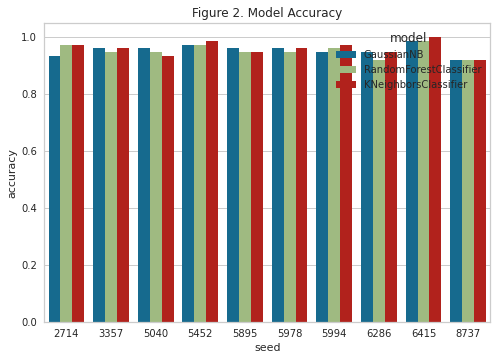

In [33]:
# plot the results
sns.barplot(
    data=df_accuracy.head(10*3),
    x='seed',
    y='accuracy',
    hue='model').set_title('Figure 2. Model Accuracy')

> ❌ Use the table below to look at the accuracy mean (bias) and standard deviation (variance) to help explain the the differences in accuracy. KNN has a low bias and high variance.

In [34]:
df_accuracy.groupby('model').describe().droplevel(axis=1, level=0).reset_index()

,model,count,mean,std,min,25%,50%,75%,max
0,GaussianNB,100.0,0.950667,0.019740,0.906667,0.933333,0.946667,0.960000,0.986667
1,KNeighborsClassifier,100.0,0.957733,0.022587,0.880000,0.946667,0.960000,0.973333,1.000000
2,RandomForestClassifier,100.0,0.945867,0.021509,0.866667,0.933333,0.946667,0.960000,0.986667


Text(0.5, 1.0, 'Figure 3. Model Accuracy - All Data')

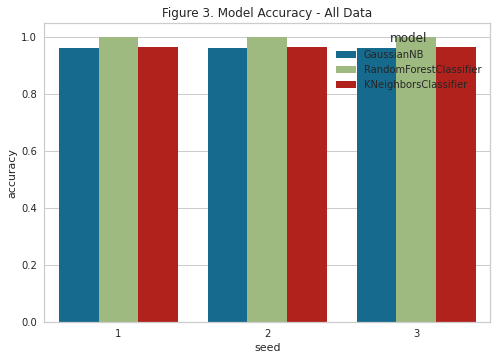

In [35]:
# get the accuracy of the models using different random seeds
df_accuracy = get_random_influence(
    models=[modeler_nb.model, modeler_rf.model, modeler_knn.model],
    random_seeds=list(range(1,4)),
    X=X,
    y=y,
    target_names=iris.target_names,
    all_data=True)

# plot the results
sns.barplot(
    data=df_accuracy,
    x='seed',
    y='accuracy',
    hue='model').set_title('Figure 3. Model Accuracy - All Data')

### 4.3 Appropriate Use [9]
When would it be appropriate to use each different classifier? 

Reference real-world situations and examples of specific data sets and explain why that classifier would be most appropriate for that use-case.

In [36]:
#Write your answer here